In [1]:
# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import shap

# System and Random Utilities
import os
import random

from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
# Set the seed for reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Set seed for random module
random.seed(seed_value)

# Set seed for numpy module
np.random.seed(seed_value)

# # Set seed for TensorFlow
# tf.random.set_seed(seed_value)

In [3]:
df = pd.read_csv('../datasets/train.csv')
print(df.shape)
df.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
df['date'] = pd.to_datetime(df['date'])

df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

df['weekday'] = df['date'].dt.day_name()
df

,date,store,item,sales,day,month,year,weekday
0,2013-01-01,1,1,13,1,1,2013,Tuesday
1,2013-01-02,1,1,11,2,1,2013,Wednesday
2,2013-01-03,1,1,14,3,1,2013,Thursday
3,2013-01-04,1,1,13,4,1,2013,Friday
4,2013-01-05,1,1,10,5,1,2013,Saturday
...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017,Wednesday
912996,2017-12-28,10,50,59,28,12,2017,Thursday
912997,2017-12-29,10,50,74,29,12,2017,Friday
912998,2017-12-30,10,50,62,30,12,2017,Saturday


In [5]:
start_date = pd.to_datetime('2013-01-01', format='%Y-%m-%d')
df['time_idx'] = (df['date'] - start_date).dt.days + 1
df

,date,store,item,sales,day,month,year,weekday,time_idx
0,2013-01-01,1,1,13,1,1,2013,Tuesday,1
1,2013-01-02,1,1,11,2,1,2013,Wednesday,2
2,2013-01-03,1,1,14,3,1,2013,Thursday,3
3,2013-01-04,1,1,13,4,1,2013,Friday,4
4,2013-01-05,1,1,10,5,1,2013,Saturday,5
...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017,Wednesday,1822
912996,2017-12-28,10,50,59,28,12,2017,Thursday,1823
912997,2017-12-29,10,50,74,29,12,2017,Friday,1824
912998,2017-12-30,10,50,62,30,12,2017,Saturday,1825


In [6]:
df_month = df.groupby(['store', 'item', 'year', 'month'])['sales'].sum().reset_index()

df_month['date'] = pd.to_datetime(df_month['year'].astype(str) + '-' + df_month['month'].astype(str), format='%Y-%m').dt.to_period('M')

start_date = pd.to_datetime('2013-01', format='%Y-%m')
df_month['time_idx'] = (df_month['date'].dt.year * 12 + df_month['date'].dt.month) - (start_date.year * 12 + start_date.month) + 1

df_month[['store',	'item']] = df_month[['store',	'item']].astype(str)
df_month

,store,item,year,month,sales,date,time_idx
0,1,1,2013,1,328,2013-01,1
1,1,1,2013,2,322,2013-02,2
2,1,1,2013,3,477,2013-03,3
3,1,1,2013,4,522,2013-04,4
4,1,1,2013,5,531,2013-05,5
...,...,...,...,...,...,...,...
29995,10,50,2017,8,2867,2017-08,56
29996,10,50,2017,9,2586,2017-09,57
29997,10,50,2017,10,2507,2017-10,58
29998,10,50,2017,11,2574,2017-11,59


In [7]:
# # Assuming you have a DataFrame named df_store1_item1_month
# df_store1_item1_month['month_year'] = df_store1_item1_month['year'].astype(str) + '-' + df_store1_item1_month['month'].apply(lambda x: str(x).zfill(2))

# df_store1_item1_month['time_idx'] = range(1, len(df_store1_item1_month) + 1)

# print(df_store1_item1_month.shape)
# df_store1_item1_month.head()

In [8]:
# df_week = df.resample('W-Mon', on='date')['sales'].sum().reset_index()
# df_week['time_idx'] = range(1, len(df_week) + 1)
# df_week

In [9]:
max_prediction_length = 6
max_encoder_length = 6
training_cutoff = df_month["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_month[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="sales",
    group_ids=["store", "item"],
    
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,

    static_categoricals=["store", "item"],
    # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    # time_varying_known_categoricals=["year", "month"],
    # variable_groups=None,  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "year", "month"],

    # time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    # time_varying_unknown_categoricals=[],
    # time_varying_unknown_reals=[
    #     "volume",
    #     "log_volume",
    #     "industry_volume",
    #     "soda_volume",
    #     "avg_max_temp",
    #     "avg_volume_by_agency",
    #     "avg_volume_by_sku",
    # ],
    # target_normalizer=GroupNormalizer(
    #     groups=["store", "item"], transformation="softplus"
    # ),  # use softplus and normalize by group

    target_normalizer=None, 

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df_month, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [10]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

tensor(319.1113)

In [11]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 8.6k


Finding best initial lr: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]
Learning rate set to 8.511380382023763
Restoring states from the checkpoint path at c:\Users\Cop\OneDrive - KASETSART UNIVERSITY\Documents\GitLab\forecasting-model\code\.lr_find_fc03a02c-1a3f-42a5-af54-45ce57a1e034.ckpt
Restored all states from the checkpoint at c:\Users\Cop\OneDrive - KASETSART UNIVERSITY\Documents\GitLab\forecasting-model\code\.lr_find_fc03a02c-1a3f-42a5-af54-45ce57a1e034.ckpt


suggested learning rate: 8.511380382023763


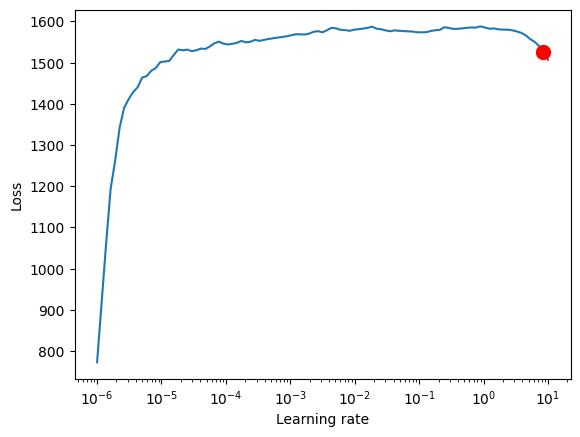

In [12]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [13]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # learning_rate=0.03,
    learning_rate=8.5,

    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 21.5k


In [14]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 760   
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.4 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Epoch 10: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s, v_num=5, train_loss_step=326.0, val_loss=397.0, train_loss_epoch=336.0]


In [15]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [16]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(779.3837)

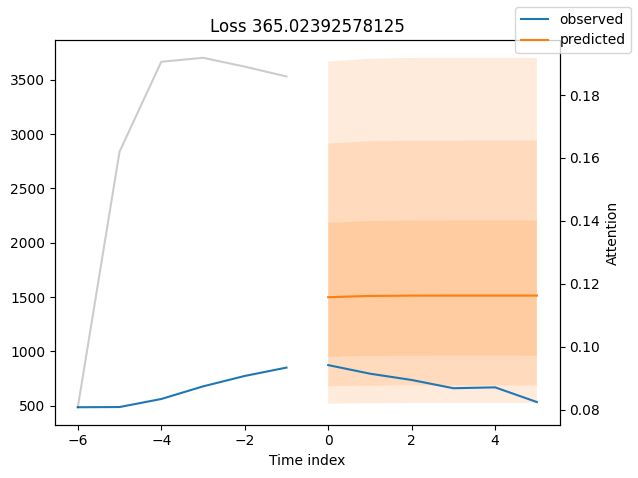

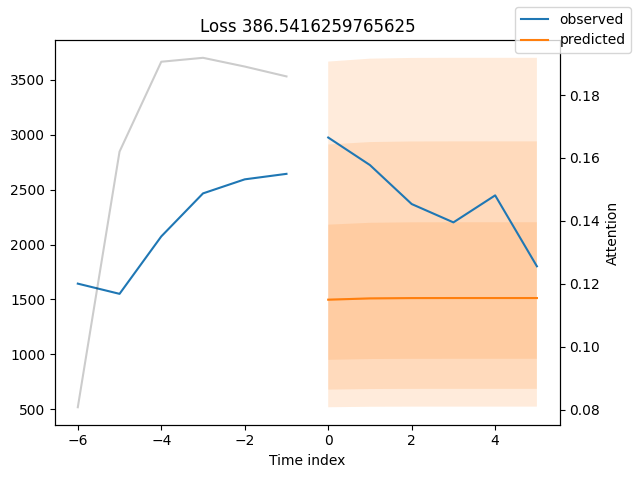

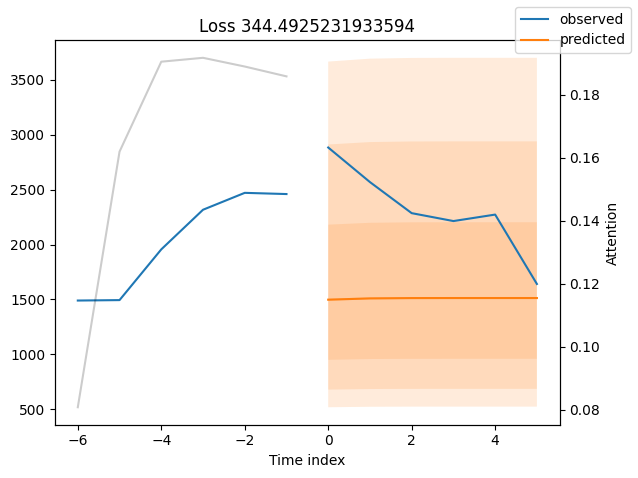

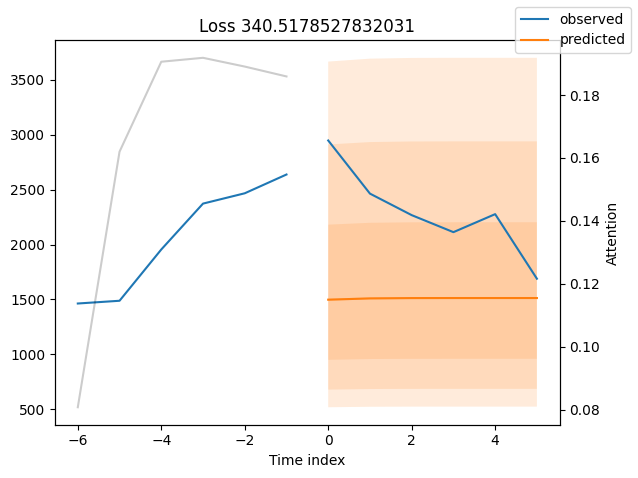

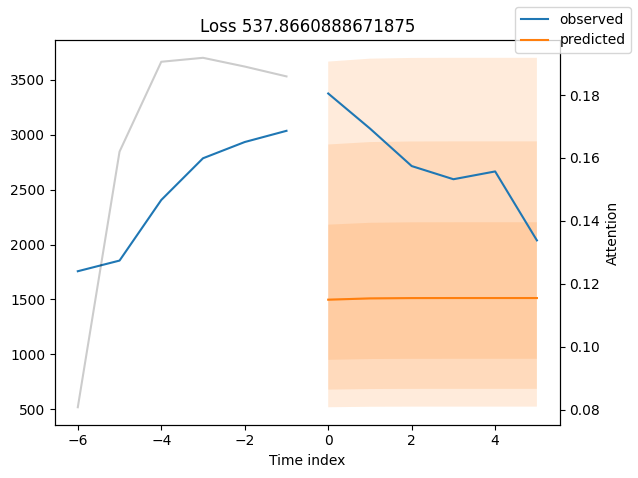

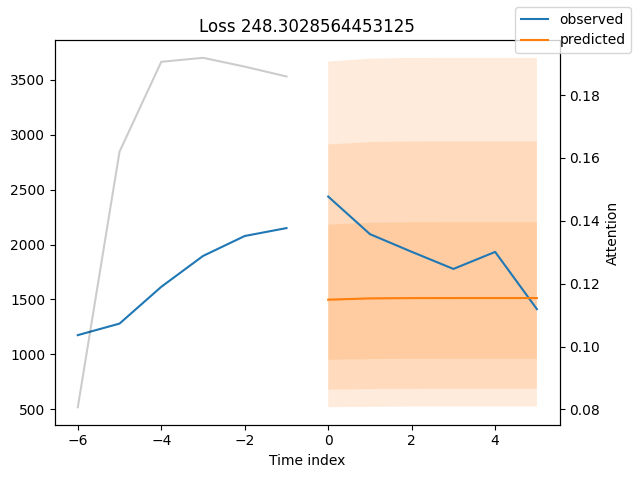

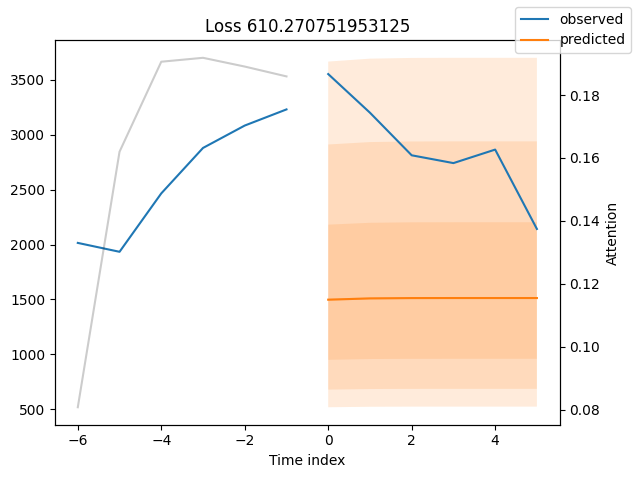

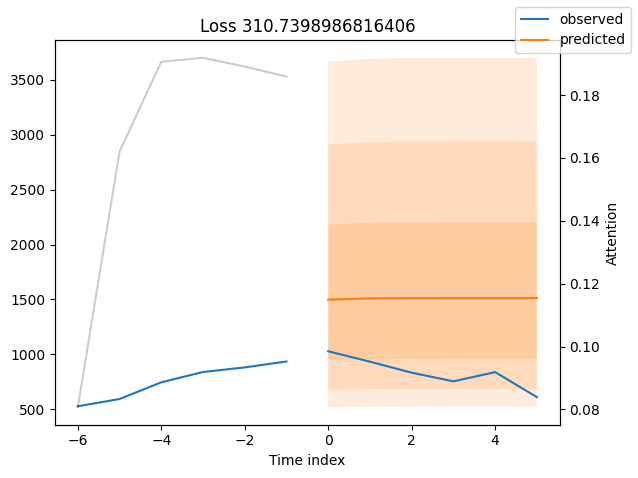

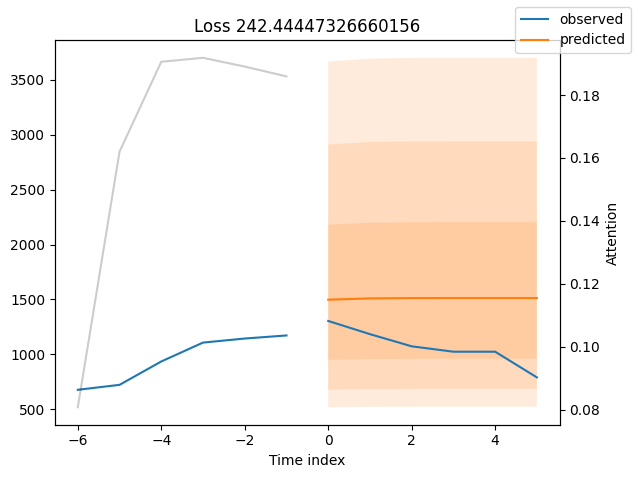

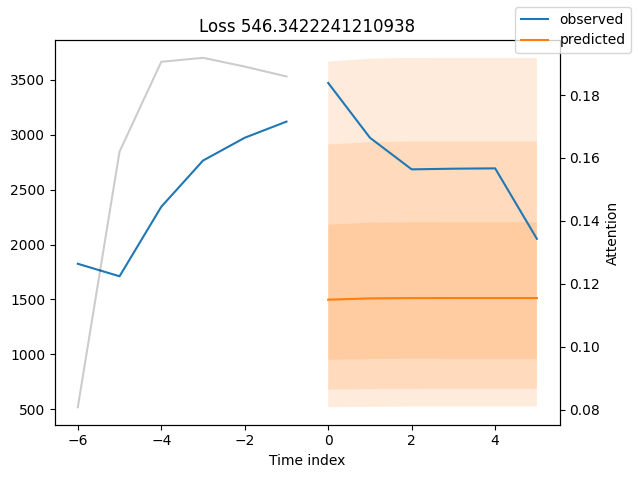

In [17]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'sales_center': <Figure size 1000x500 with 2 Axes>,
 'sales_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'year': <Figure size 1000x500 with 2 Axes>,
 'month': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'store': <Figure size 640x480 with 2 Axes>,
 'item': <Figure size 1000x500 with 2 Axes>}

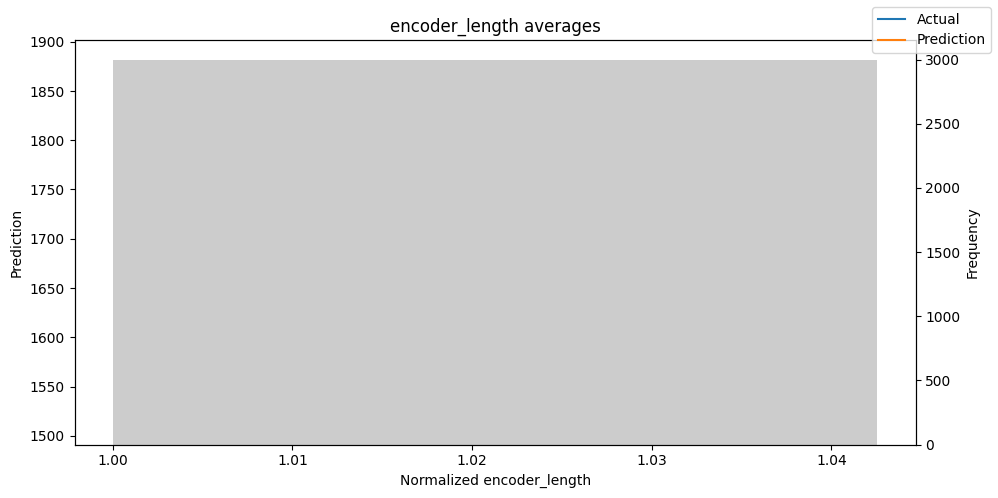

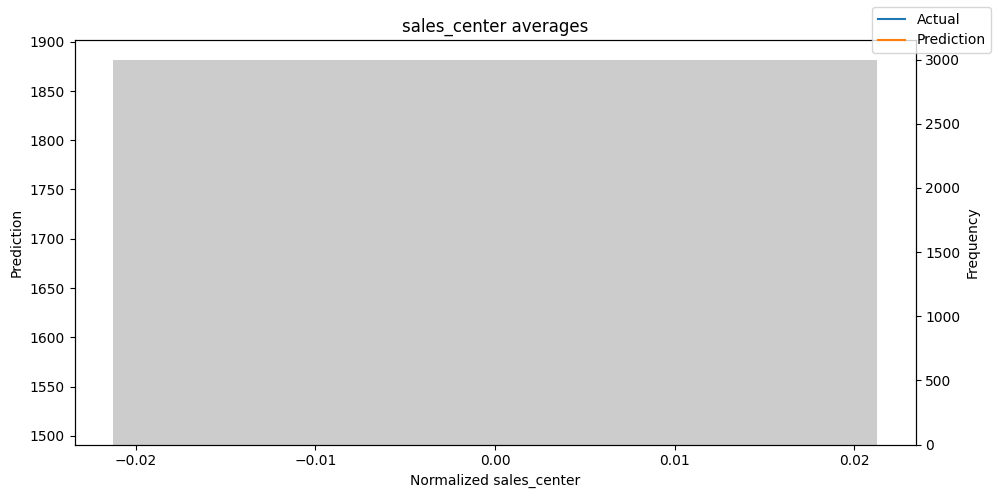

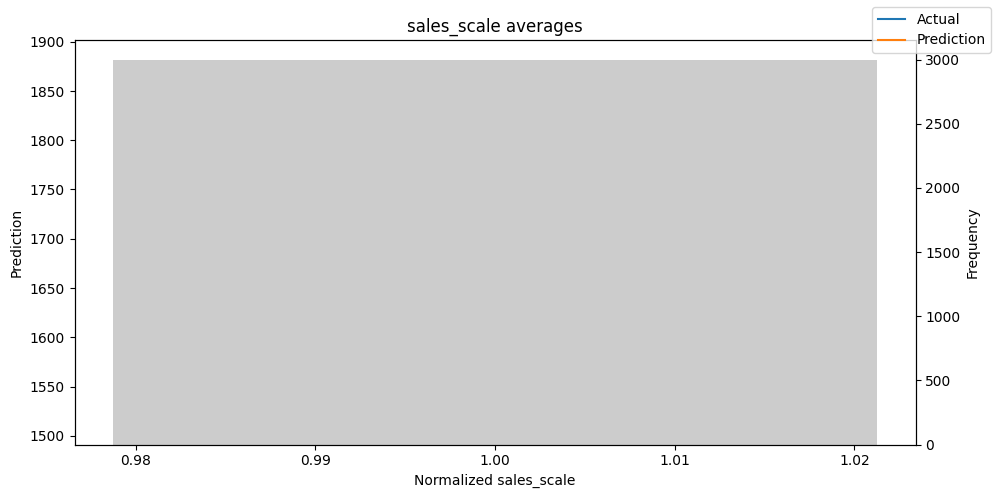

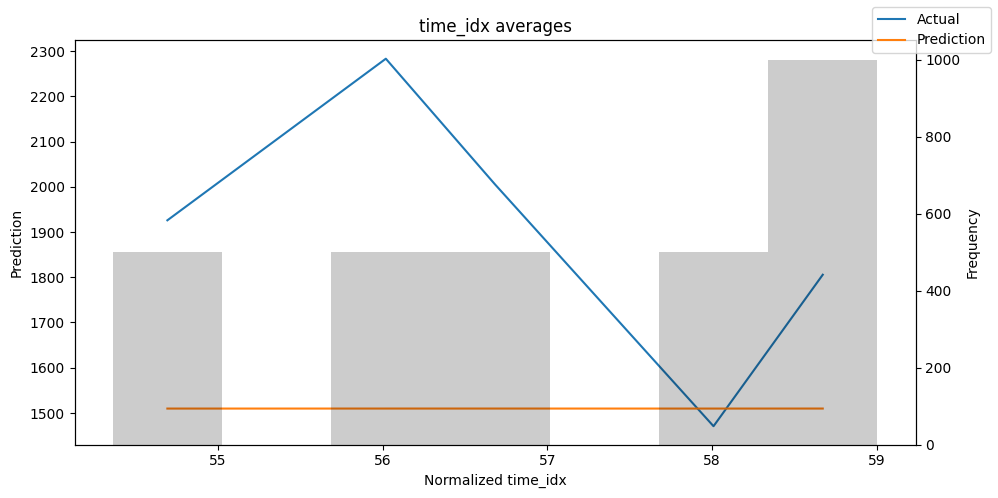

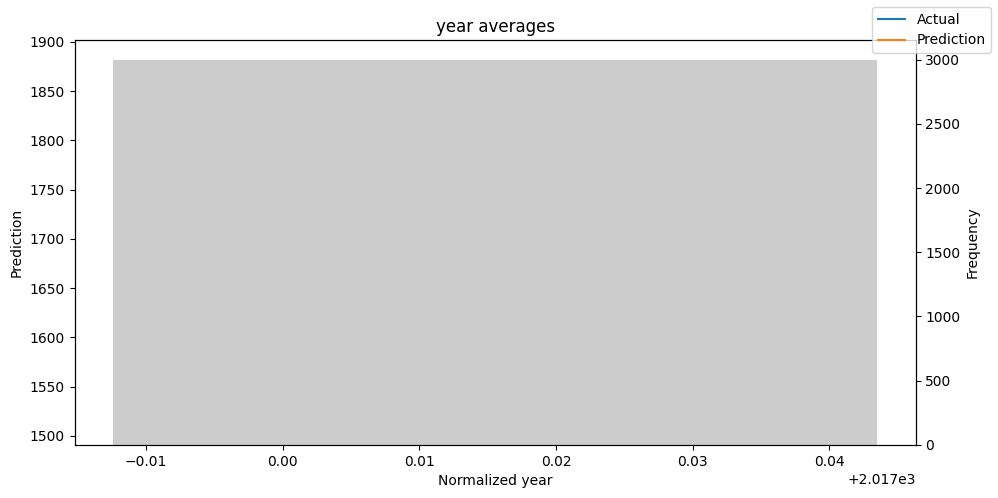

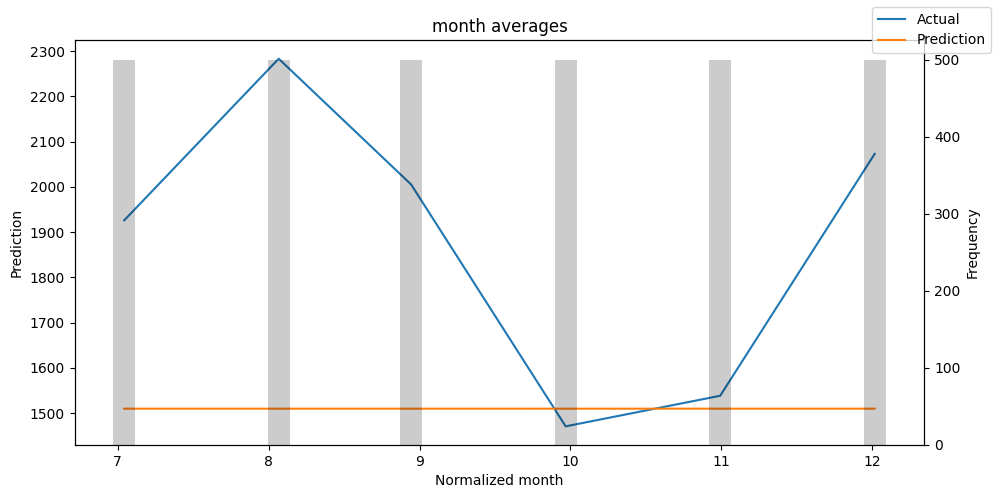

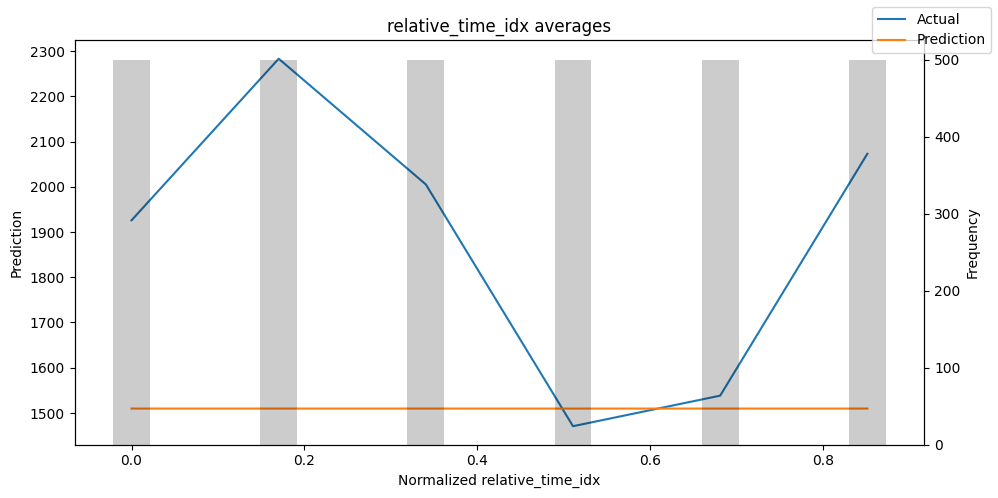

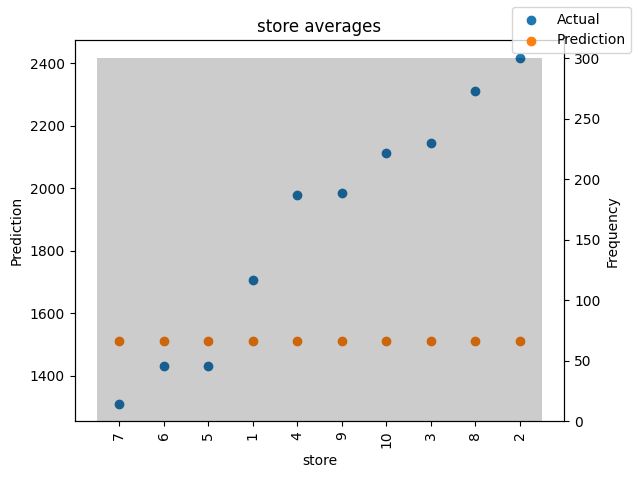

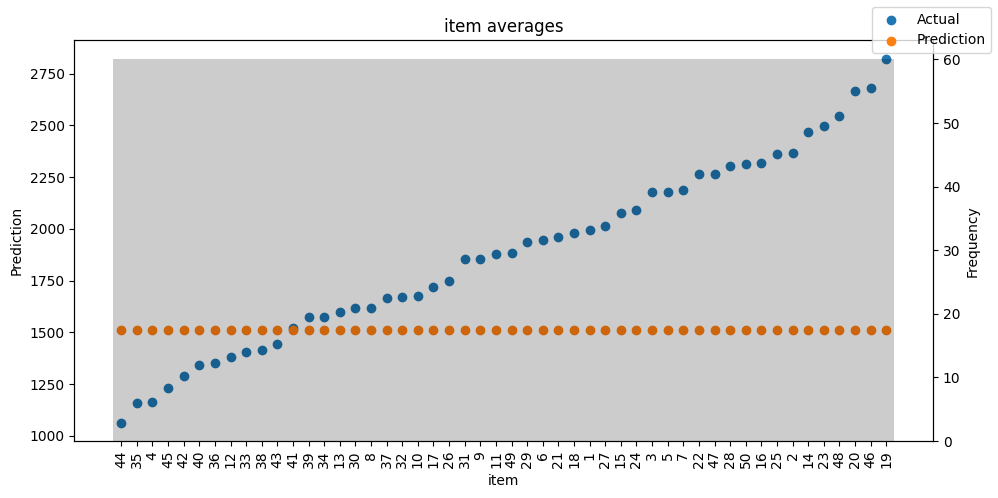

In [18]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)